In [1]:
import glob
import numpy as np
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.python.keras import layers
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.python.keras import models
import tensorflow as tf
from sklearn.preprocessing import LabelBinarizer
from sklearn import metrics
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def read_many(path):
    """
    Read all imagens in directory.
    
    Parameters
    ----------
    path: str
        Dataset path of a class (COVID or NON-COVID).
    
    Returns
    -------
    out : [ndarray]
        List of images.
    """
    # Get the path of all images
    list_imgs = list(glob.glob(path))
    out = []
    
    # Load all images of the given paths
    for i in range(len(list_imgs)):
        # Read the image in shape of (244, 244, 3)
        try:
            img = image.load_img(list_imgs[i], target_size=(224, 224, 3))
            x = image.img_to_array(img)
            out.append(x)
        # Print error
        except ValueError:
            print('Error reading the following image:', list_imgs[i])
    
    # Return the loaded images
    return out


def load_dir(paths):
    """
    Read images of COVID and NON-COVID cases.
    
    Parameters
    ----------
    paths: [str]
        Original and augmented dataset paths.
    
    Returns
    -------
    X : [ndarray]
        List of images.
    Y : [str]
        Labels of the images (i.e., 0 - NON-COVID; 1 - COVID).
    """
    # Arrays of images of COVID and NON-COVID cases
    covid = []
    non_covid = []
    
    # Read images
    for path in paths:
        # Read images of covid cases
        covid.extend(read_many('{}/COVID/*'.format(path)))
        # Read images of non-covid cases
        non_covid.extend(read_many('{}/NON_COVID/*'.format(path)))
    
    # Set COVID classes
    y_covid = np.asarray([1] * len(covid))
    y_non_covid = np.asarray([0] * len(non_covid))
    
    # Merge the read images
    X = np.concatenate([np.array(covid), np.array(non_covid)]) / 255
    Y = np.concatenate([np.array(y_covid), np.array(y_non_covid)])
    lb = LabelBinarizer()
    Y=lb.fit_transform(Y)
    
    assert len(X) == len(Y), 'The number of images and the number of classes are different!'
    print('Images read:', len(X))
    
    # Return the read images and their labels
    return (X, Y)

In [3]:
def load_models(path):
    models_name=list(glob.glob(path+"*"))
    models={}
    
    for model_name in models_name:
        #mprint(models_name)
        file=model_name.split("/")[-1]
        name=file.split(".")[0]
        models[name]=tf.keras.models.load_model(model_name)
        
    return models
    

In [4]:
TestX, TestY = load_dir(['Dataset/Test'])

Images read: 800


In [5]:
models=load_models("modelos/")

In [6]:
models.keys()

dict_keys(['Rotation', 'Sharpness', 'Noise', 'Contrast', 'None'])

In [7]:
preds={}
for name in models.keys():
    print (name)
    preds[name]=models[name].predict(TestX)

Rotation
Sharpness
Noise
Contrast
None


In [24]:
lb = LabelBinarizer()
metrics_names={"balanced accuracy": [],"f1-score":[],"precision":[],"recall":[]}
confusion_matrix={}
order=["None","Noise","Rotation","Sharpness","Contrast"]
data=[]
for pred_name in order:
    data.append(preds[pred_name])
    Y=lb.fit_transform(preds[pred_name]>0.5)
    print (pred_name)
    metrics_names["balanced accuracy"].append(metrics.balanced_accuracy_score(TestY, Y))
    metrics_names["f1-score"].append(metrics.f1_score(TestY, Y))
    metrics_names["precision"].append(metrics.precision_score(TestY, Y))
    metrics_names["recall"].append(metrics.recall_score(TestY, Y))
    confusion_matrix[pred_name]=metrics.confusion_matrix(TestY,Y)
    print(metrics.classification_report(TestY, Y))
    print ('\n'*10)


df2 = pd.DataFrame.from_dict(metrics_names, orient='index',columns=order)


None
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       600
           1       0.81      0.92      0.86       200

    accuracy                           0.93       800
   macro avg       0.89      0.92      0.90       800
weighted avg       0.93      0.93      0.93       800












Noise
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       600
           1       0.89      0.87      0.88       200

    accuracy                           0.94       800
   macro avg       0.92      0.92      0.92       800
weighted avg       0.94      0.94      0.94       800












Rotation
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       600
           1       0.93      0.86      0.90       200

    accuracy                           0.95       800
   macro avg       0.94      0.92      0.93       800
weighted avg       0.95      0.9

In [9]:
df2

None     Noise  Rotation  Sharpness  Contrast
balanced accuracy  0.921667  0.917500  0.920000   0.946667  0.916667
f1-score           0.859155  0.881013  0.895833   0.924242  0.894737
precision          0.809735  0.892308  0.934783   0.933673  0.944444
recall             0.915000  0.870000  0.860000   0.915000  0.850000

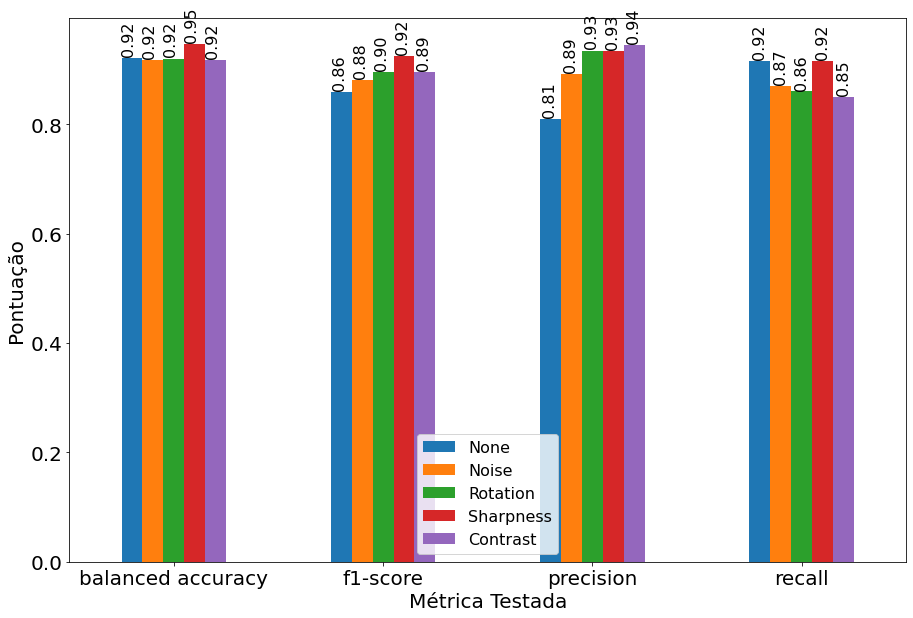

In [10]:

ax = df2.plot.bar(rot=0,figsize=(15, 10),fontsize=20)
for p in ax.patches:
    ax.annotate("{:.2f}".format(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.010),fontsize=16,rotation=90)
    
ax.set_ylabel("Pontuação",fontsize=20)
ax.set_xlabel("Métrica Testada",fontsize=20)
ax.legend(loc=0,fontsize=16)  
#plt.tick_params( labelsize=17)



    

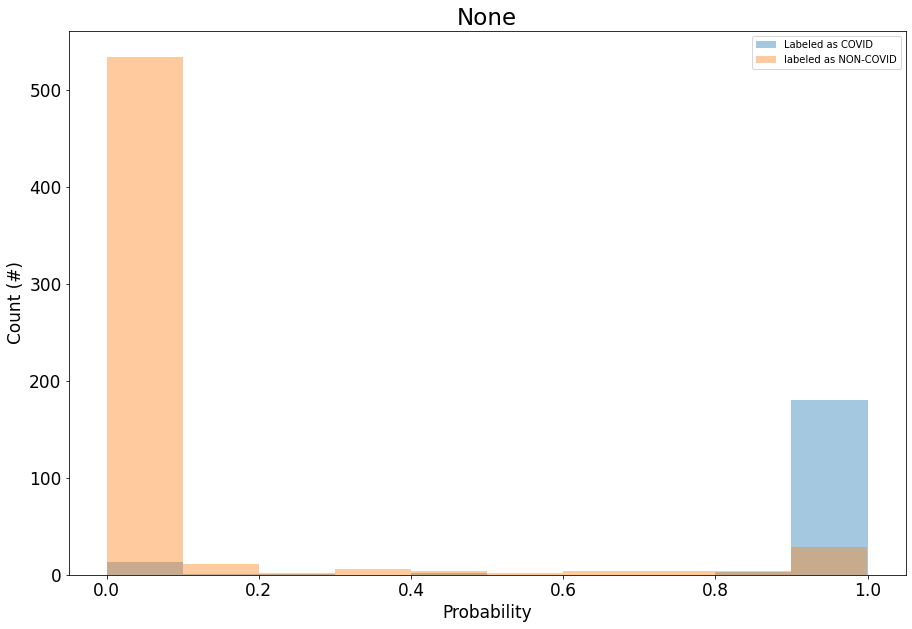

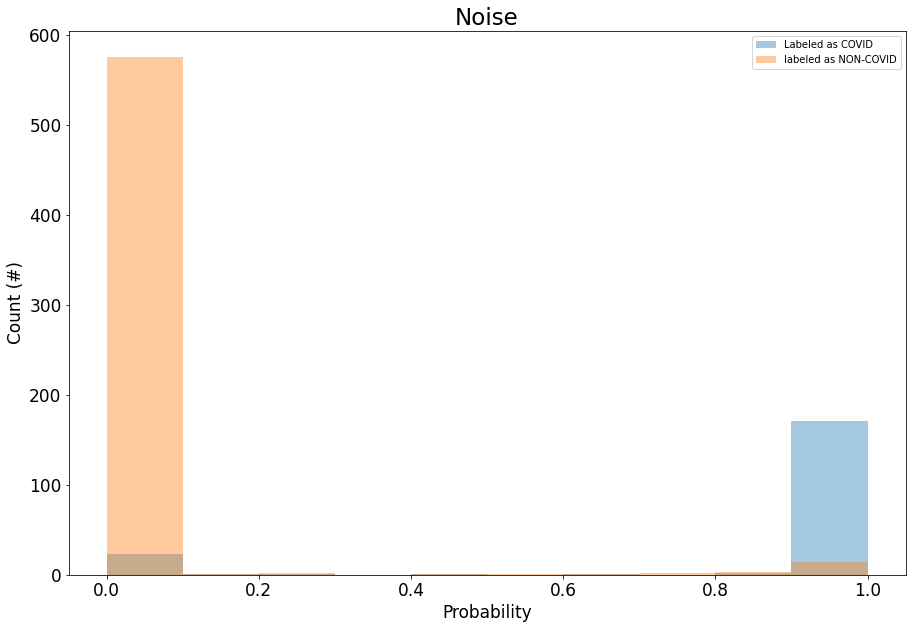

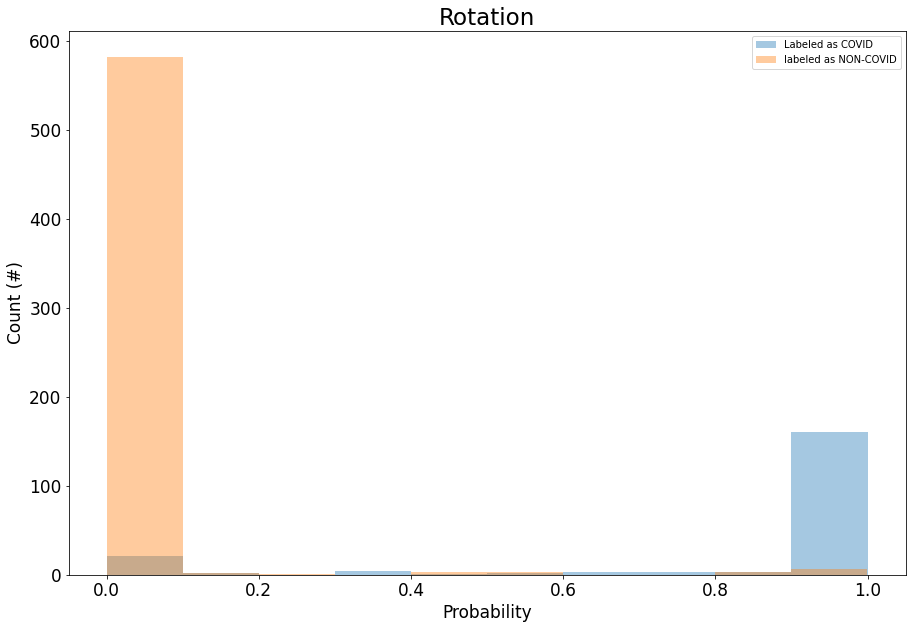

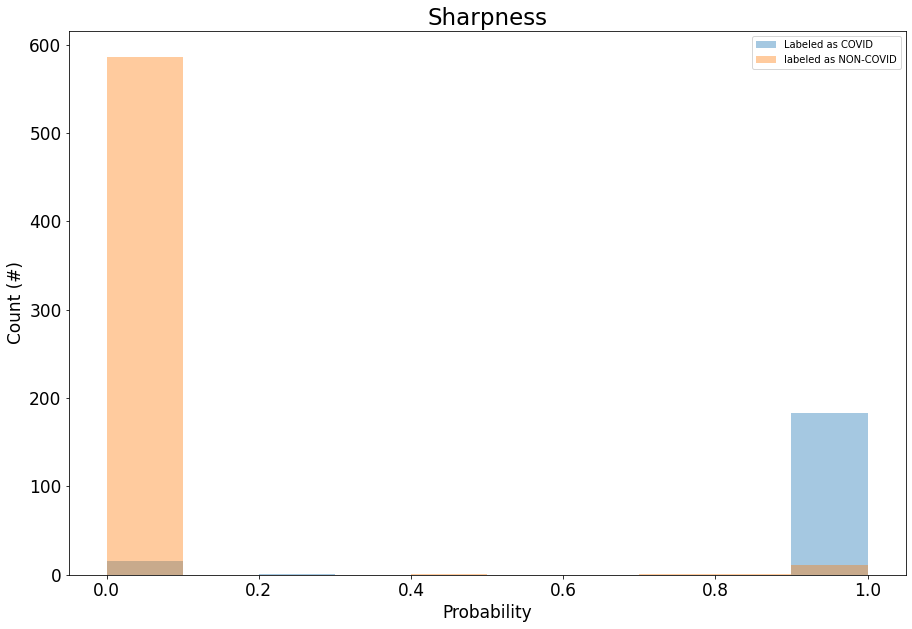

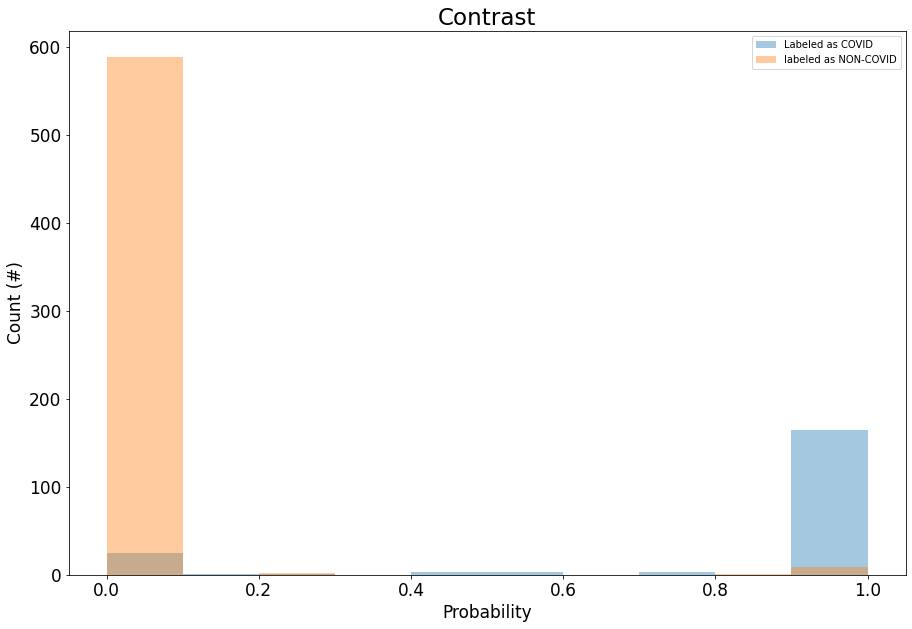

In [22]:

for i in order:
    plt.figure(figsize=(15,10))
    sns.distplot(preds[i][TestY==1],kde=False,bins=10)
    sns.distplot(preds[i][TestY==0],kde=False,bins=10)
    plt.legend(["Labeled as COVID", "labeled as NON-COVID"])
    plt.title(i,fontsize=23)
    plt.ylabel("Count (#)",fontsize=17)
    plt.xlabel ("Probability",fontsize=17)
    plt.tick_params( labelsize=17)
    plt.show()
    
#sns.distplot(preds["None"],kde=False,bins=10)


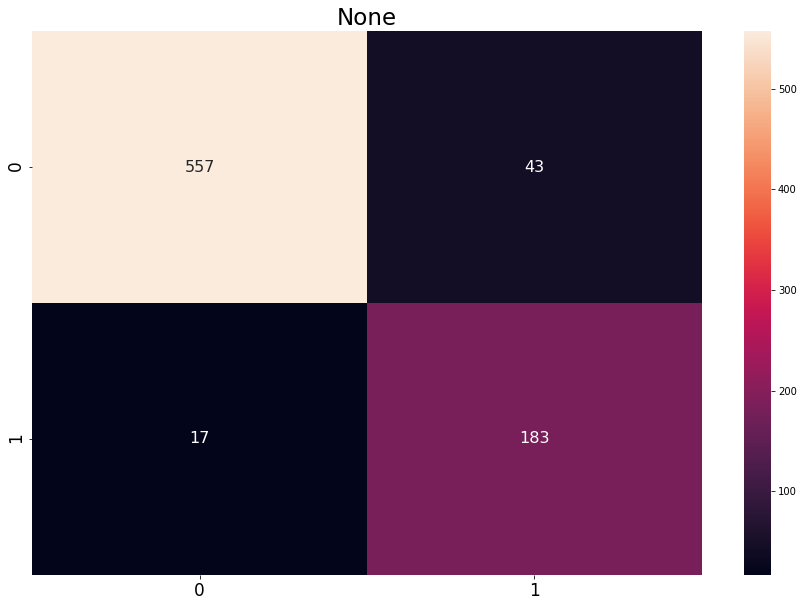

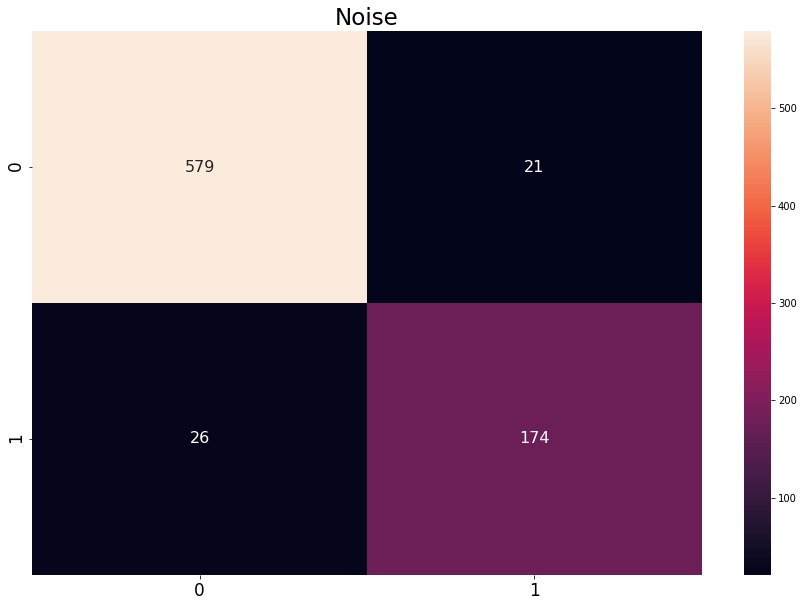

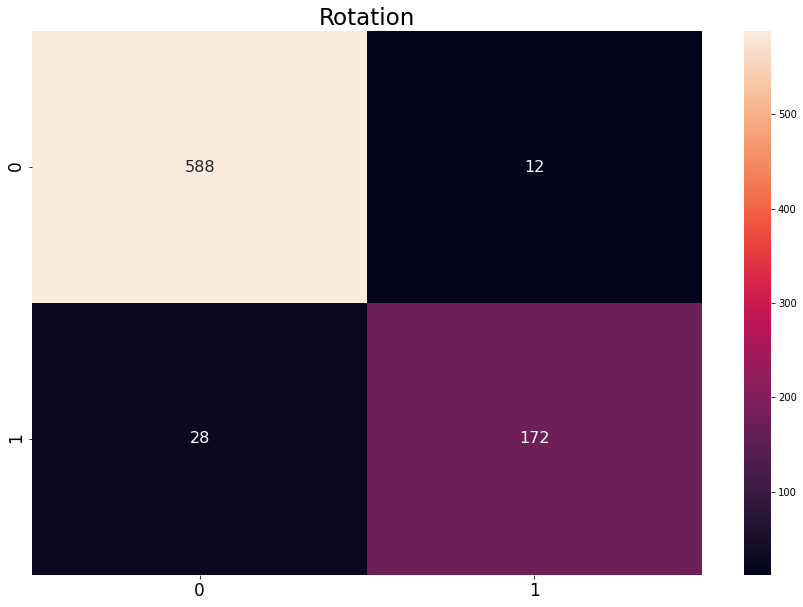

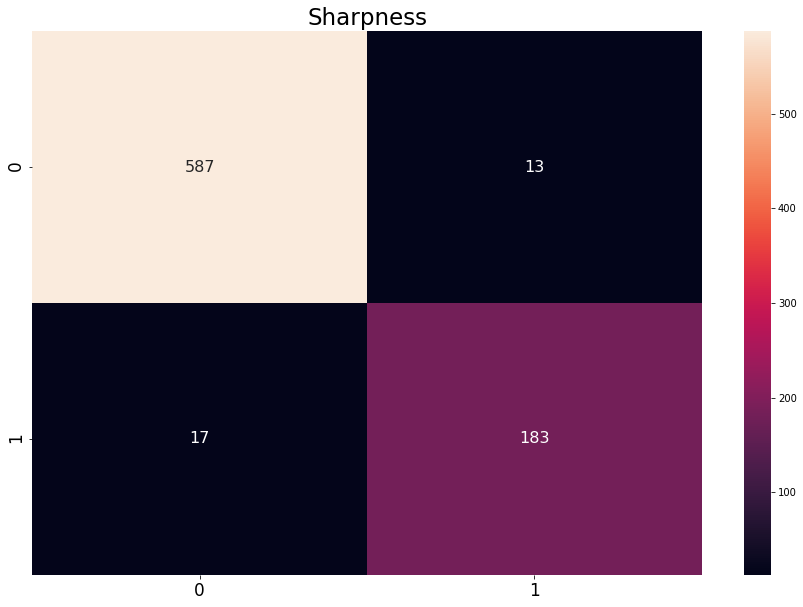

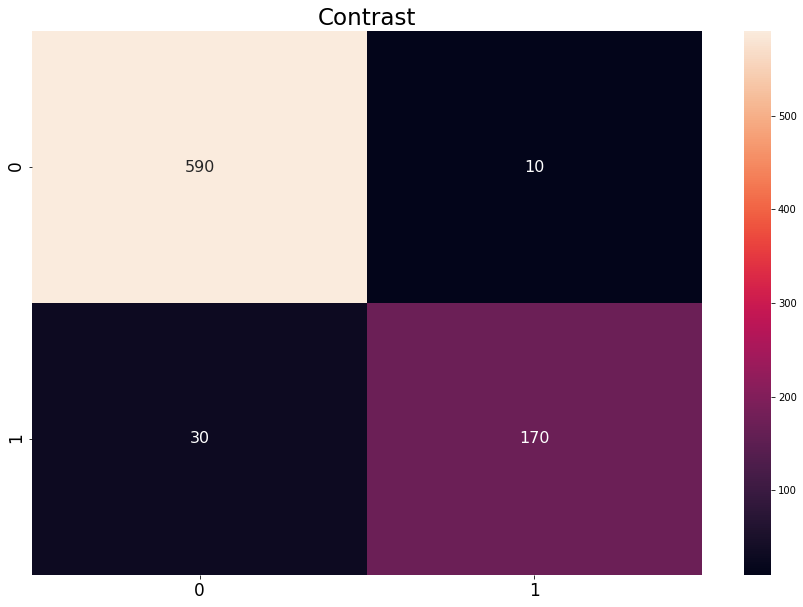

In [28]:
for i in order:
    plt.figure(figsize=(15,10))
    sns.heatmap(confusion_matrix[i], annot=True, fmt='g',annot_kws={"size": 16})
    #plt.legend(["Labeled as COVID", "labeled as NON-COVID"])
    plt.title(i,fontsize=23)
    #plt.ylabel("Count (#)",fontsize=17)
    #plt.xlabel ("Probability",fontsize=17)
    plt.tick_params( labelsize=17)
    plt.show()
    